In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import cProfile
import importlib
import numpy as np
import os
import yaml
from generator import MCTS
from language import Language
from node import MolSentenceNode
from utils import add_sep, class_from_package, HELMConverter

config_path = "config/mcts_d_score_replication.yaml"
with open(os.path.join(repo_root, config_path)) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, device, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "device", "lang_path"))
if lang_path is None:
    lang_name = os.path.basename(os.path.normpath(model_dir)) + ".lang"
    lang_path = add_sep(model_dir) + lang_name
lang = Language.load(os.path.join(repo_root, lang_path))
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=os.path.join(repo_root, model_dir), device=device)

reward_class = class_from_package("reward", conf.get("reward_class"))
reward = reward_class(**conf.get("reward_conf", {}))
policy_class = class_from_package("policy", conf.get("policy_class"))
policy = policy_class(**conf.get("policy_conf", {}))

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Search is started.
Search is completed.


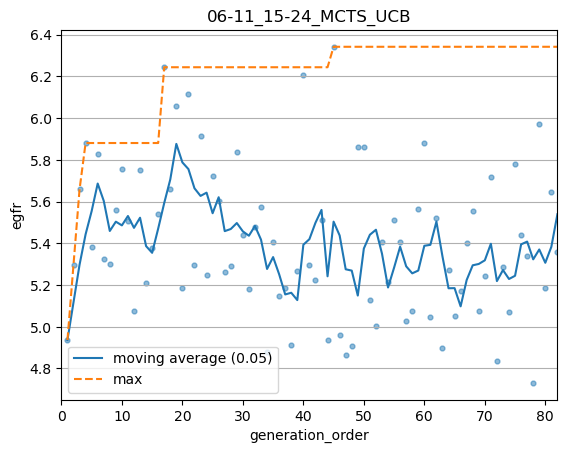

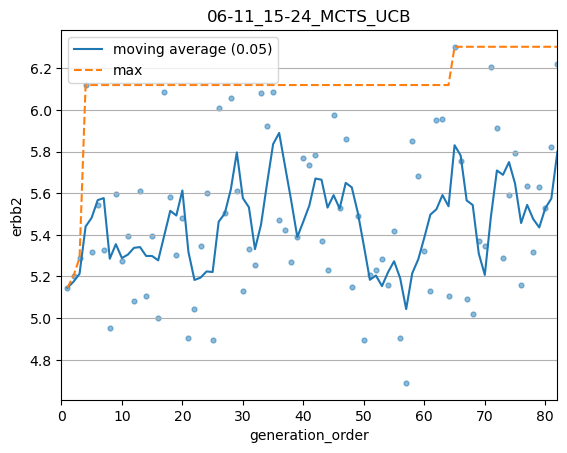

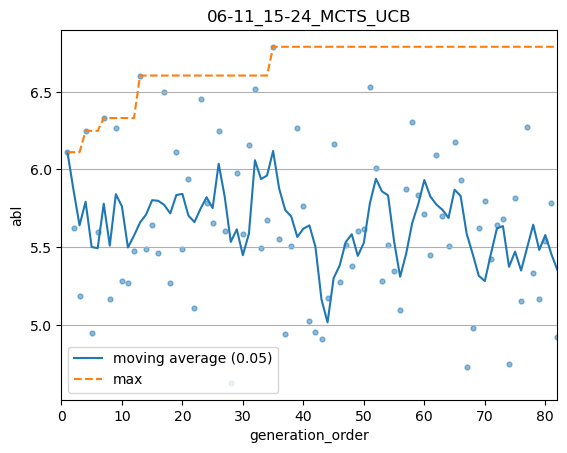

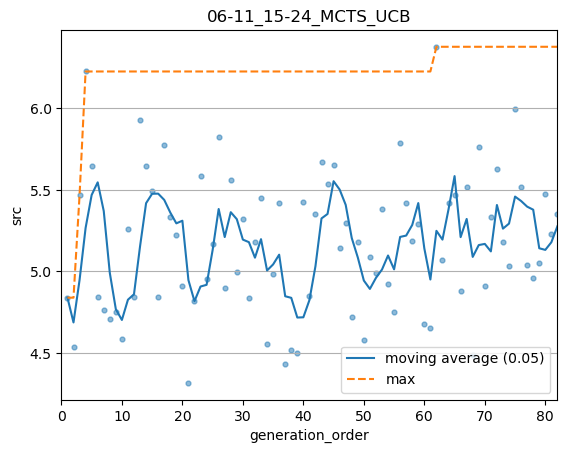

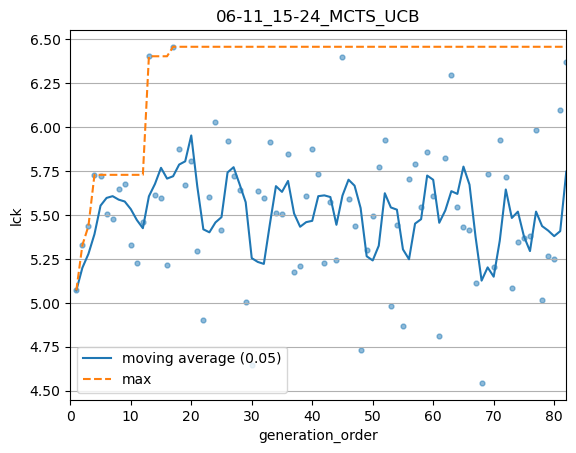

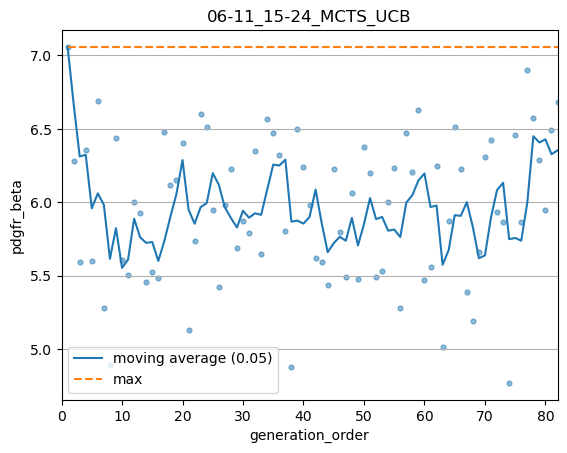

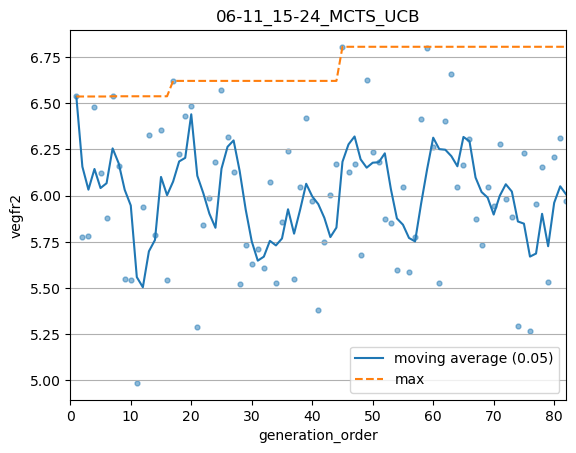

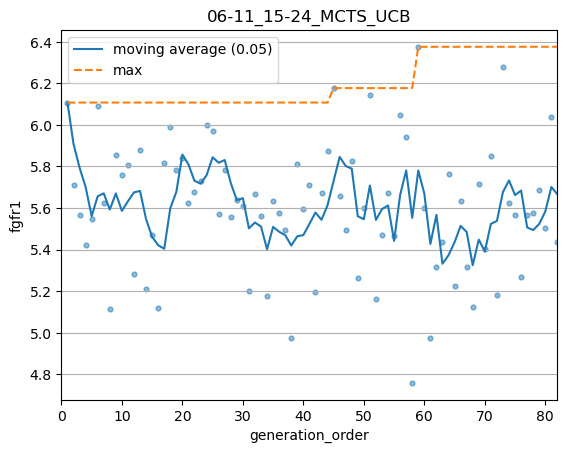

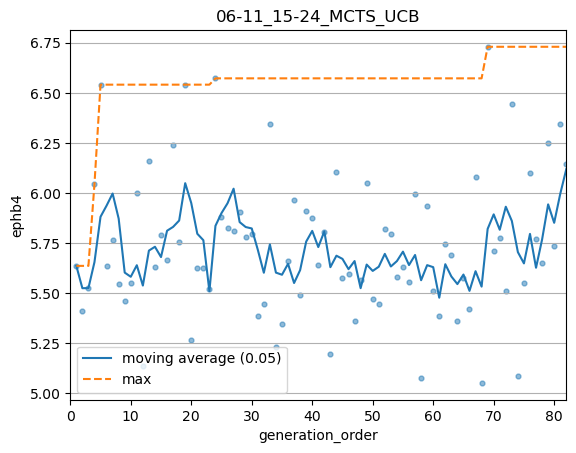

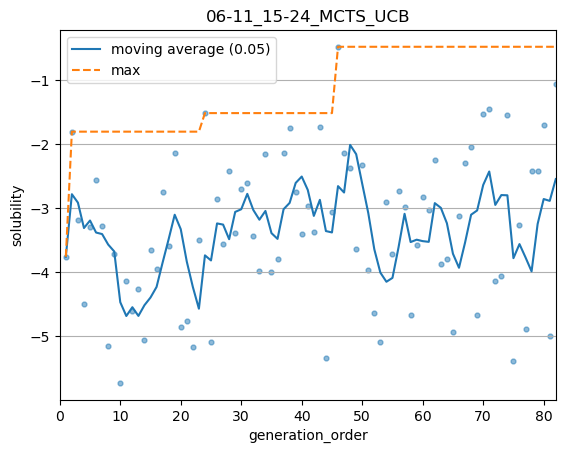

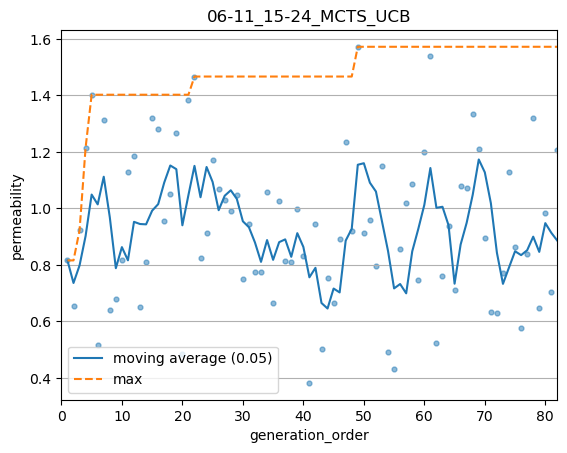

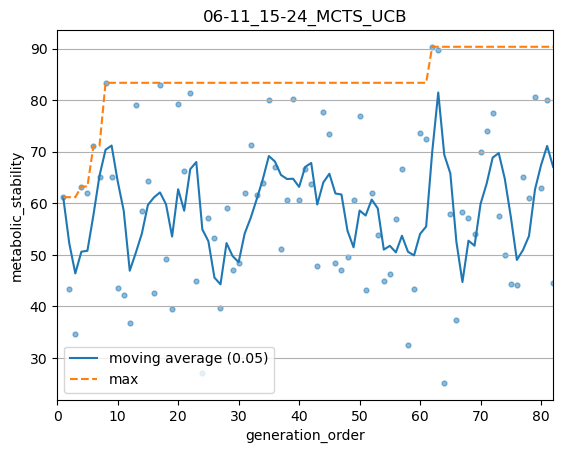

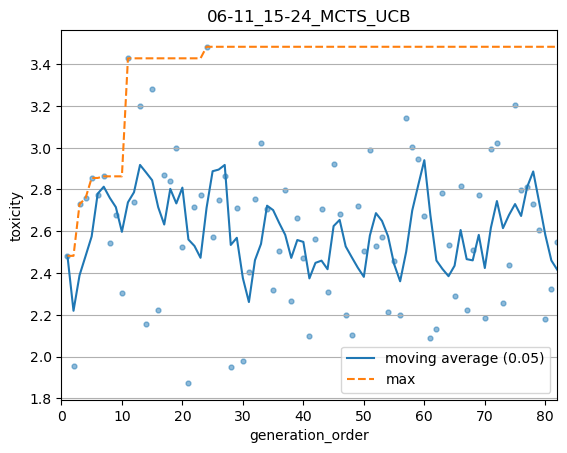

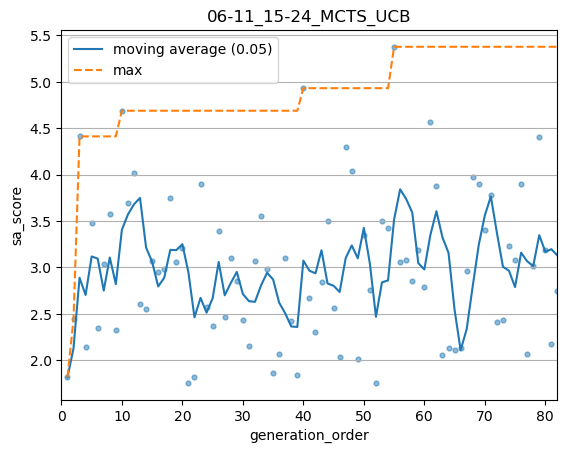

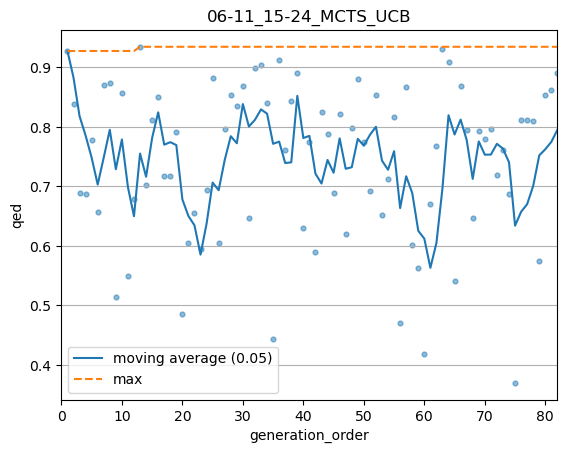

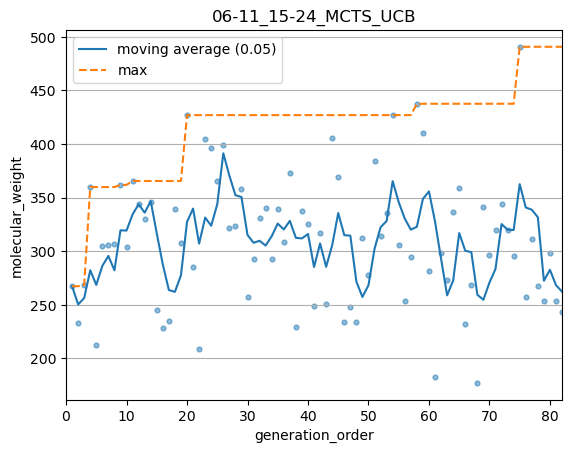

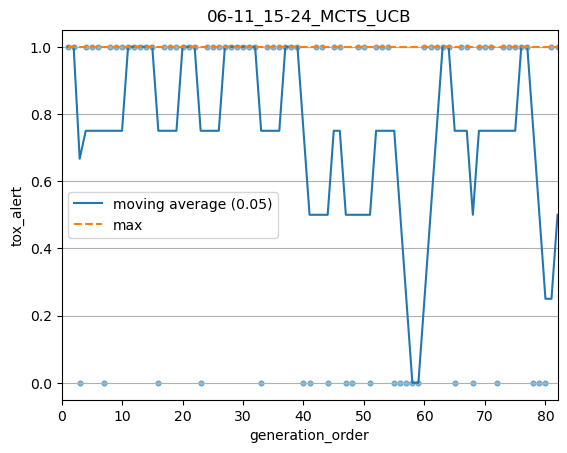

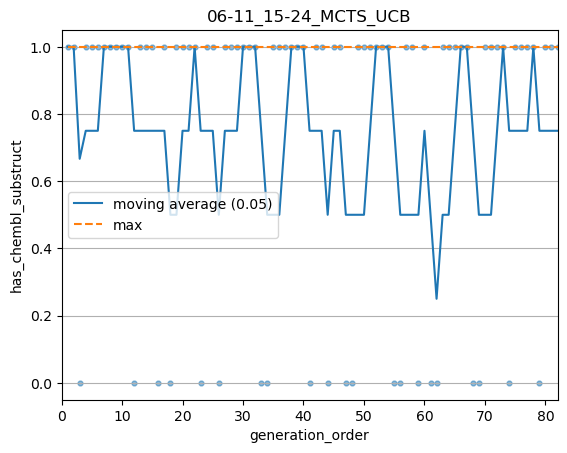

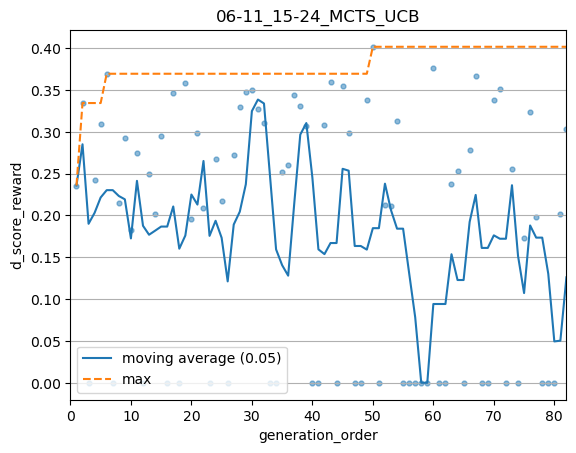

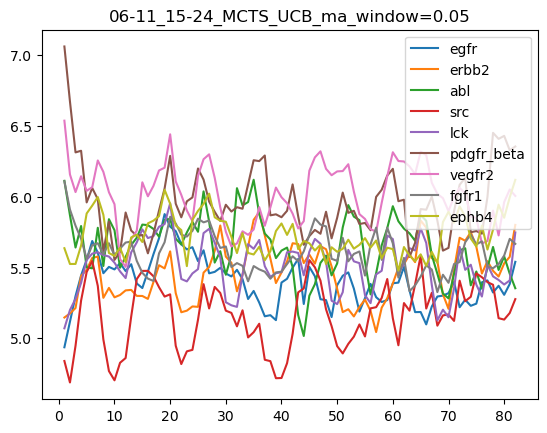

number of generated nodes: 82
valid rate: 0.5
node_per_sec: 5.40447631332779


In [4]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') # invalid mols are already logged

root = MolSentenceNode.bos_node(lang) # TODO: change after root node generalization

generator = MCTS(root=root, transition=model, reward=reward, policy=policy, filters=filters, filtered_reward=conf.get("filtered_reward"), output_dir=conf.get("output_dir"), **conf.get("generator_conf"))
src = os.path.join(repo_root, config_path)
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
# cProfile.run("generator.generate(root=root, **generation_conf)"")
generator.plot(**conf.get("plot_conf"))
generator.analyze()

In [ ]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [7]:
#load mcts
load_path = os.path.join(output_dir, "06-09_22-15_MCTS_PUCT/test.mcts")
generator = MCTS.load(load_path, model)